In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline



import os
import itertools
from glob import glob
import PIL
from PIL import Image
from scipy import ndimage 
import scipy
import sys

 

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

 

#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
#from keras.layers.normalization import BatchNormalization

 

#import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import Conv2D
#from keras.layers import MaxPooling2D
#from keras.layers import Flatten
#from keras.layers import Dense
#from keras.preprocessing.image import ImageDataGenerator
#from keras.layers import Dropout
import scipy
from scipy import ndimage
import scipy.misc
import imageio
import numpy
import matplotlib as plt
from matplotlib.pyplot import imread


In [2]:
train_data_dir_positive = "C:/Users/Ruoxin Wang/Desktop/concerete_crack_images/concerete_crack_images/training/Positive/"
train_data_dir_negative = "C:/Users/Ruoxin Wang/Desktop/concerete_crack_images/concerete_crack_images/training/Negative/"

train_imgs_p = os.listdir(train_data_dir_positive)
train_imgs_n = os.listdir(train_data_dir_negative)

print(len(train_imgs_p))
print(len(train_imgs_n))



16070
16037


In [3]:
import imageio
import scipy.misc
num_px = 64

def extractFeaturesAndLabels(dir, impg_dataset, category):
    X = np.zeros((len(impg_dataset), num_px*num_px*3))
    y = np.zeros((len(impg_dataset)))
    for i in range(0,len(impg_dataset)) :
    #Read an image from a file as an array.
    #The different colour bands/channels are stored 
    #in the third dimension, such that a 
    #grey-image is MxN, an RGB-image MxNx3 
        image = np.array(imageio.imread(dir + impg_dataset[i])) 
    #image = np.array(imageio.imread(dir + impg_dataset[i])) 
    
    # Resize the image. Size of the output image (height, width)
        image = Image.fromarray(image).resize(size=(num_px, num_px))
        image = np.array(image)
    
    # Convert the matrix to a vector
        image = image.reshape((1, num_px*num_px*3)).T     

    # Note that RGB (Red, Green, Blue) are 8 bit each.
    # Hence, the range for each individual colour is 0-255 (as 2^8 = 256 possibilities).
    # By dividing by 255, Convert the 0-255 range to a 0.0-1.0 range where 0.0 means 0 (0x00) and 1.0 means 255 (0xFF).
        image = image/255.0
    
        image = image.reshape((num_px*num_px*3,1))
        for j in range(0,num_px*num_px*3) :
            X[i][j] = image[j][0]
        
        if category == 'positive':
            y[i] = 1
        else:
            y[i] = 0

    y = y.astype(int)
  
    return(X, y)

def get_accuracy(model, X, y):
    y_pred = model.predict(X)

    if sys.version_info < (3, 0):
        accuracy = ((np.sum(y == y_pred, axis=0)).astype('float') /
            X.shape[0])
    else:
        accuracy = np.sum(y == y_pred, axis=0) / X.shape[0]

  #print('Accuracy: %.2f%%' % (accuracy * 100))
  
    return(accuracy * 100)




In [4]:
X_train_p, y_train_p = extractFeaturesAndLabels(train_data_dir_positive, train_imgs_p, 'positive')
X_train_n, y_train_n = extractFeaturesAndLabels(train_data_dir_negative, train_imgs_n, 'negative')
X_train_mixed = np.concatenate([X_train_p,X_train_n])
y_train_mixed = np.concatenate([y_train_p,y_train_n])



In [5]:
x_train, x_test, y_train, y_test = train_test_split(X_train_mixed, y_train_mixed, test_size=0.25, random_state=1)



In [6]:
#pip install matplotlib

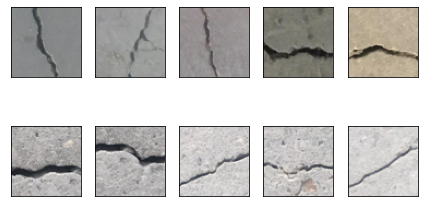

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train_p[y_train_p == 1][i].reshape(num_px, num_px, 3)
    ax[i].imshow(img)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

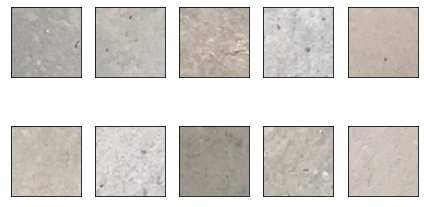

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train_n[y_train_n == 0][i].reshape(num_px, num_px, 3)
    ax[i].imshow(img)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [9]:
import numpy as np
from scipy.special import expit
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_output : int
        Number of output units, should be equal to the
        number of unique class labels.
    n_features : int
        Number of features (dimensions) in the target dataset.
        Should be equal to the number of columns in the X array.
    n_hidden : int (default: 30)
        Number of hidden units.
    l1 : float (default: 0.0)
        Lambda value for L1-regularization.
        No regularization if l1=0.0 (default)
    l2 : float (default: 0.0)
        Lambda value for L2-regularization.
        No regularization if l2=0.0 (default)
    epochs : int (default: 500)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    alpha : float (default: 0.0)
        Momentum constant. Factor multiplied with the
        gradient of the previous epoch t-1 to improve
        learning speed
        w(t) := w(t) - (grad(t) + alpha*grad(t-1))
    decrease_const : float (default: 0.0)
        Decrease constant. Shrinks the learning rate
        after each epoch via eta / (1 + epoch*decrease_const)
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatches : int (default: 1)
        Divides training data into k minibatches for efficiency.
        Normal gradient descent learning if k=1 (default).
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.

    Attributes
    -----------
    cost_ : list
      Sum of squared errors after each epoch.

    """
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=None):

        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_labels, n_samples)

        """
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        w1 = np.random.uniform(-1.0, 1.0,
                               size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0,
                               size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)

        Uses scipy.special.expit to avoid overflow
        error for very small input values z.

        """
        # return 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    def _sigmoid_gradient(self, z):
        """Compute gradient of the logistic function"""
        sg = self._sigmoid(z)
        return sg * (1.0 - sg)

    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new

    def _feedforward(self, X, w1, w2):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ----------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        z3 : array, shape = [n_output_units, n_samples]
            Net input of output layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.

        """
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        """Compute L2-regularization cost"""
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) +
                                np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        """Compute L1-regularization cost"""
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() +
                                np.abs(w2[:, 1:]).sum())

    def _get_cost(self, y_enc, output, w1, w2):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        output : array, shape = [n_output_units, n_samples]
            Activation of the output layer (feedforward)
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        cost : float
            Regularized cost.

        """
        term1 = -y_enc * (np.log(output))
        term2 = (1.0 - y_enc) * np.log(1.0 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        """ Compute gradient step using backpropagation.

        Parameters
        ------------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        grad1 : array, shape = [n_hidden_units, n_features]
            Gradient of the weight matrix w1.
        grad2 : array, shape = [n_output_units, n_hidden_units]
            Gradient of the weight matrix w2.

        """
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += self.l2 * w1[:, 1:]
        grad1[:, 1:] += self.l1 * np.sign(w1[:, 1:])
        grad2[:, 1:] += self.l2 * w2[:, 1:]
        grad2[:, 1:] += self.l1 * np.sign(w2[:, 1:])

        return grad1, grad2

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                 'Use X[:,None] for 1-feature classification,'
                                 '\nor X[[i]] for 1-sample classification')

        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data.

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        y : array, shape = [n_samples]
            Target class labels.
        print_progress : bool (default: False)
            Prints progress as the number of epochs
            to stderr.

        Returns:
        ----------
        self

        """
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx],
                                                       self.w1,
                                                       self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self

Epoch: 50/50

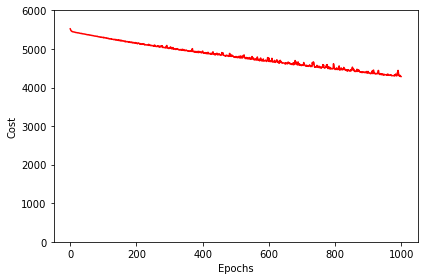

Training accuracy: 90.22%
Test accuracy: 89.30%


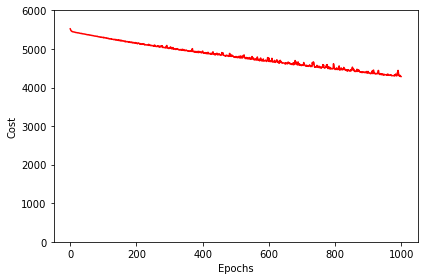

Training accuracy: 90.22%
Test accuracy: 89.30%


In [10]:
nn = NeuralNetMLP(n_output=2, 
                  n_features=x_train.shape[1], 
                  n_hidden=10,
                  l2=0.1, 
                  l1=0.1, 
                  epochs=50, 
                  eta=0.0001,
                  alpha=0.1, 
                  decrease_const=0.00001,
                  minibatches=100, 
                  shuffle=True,
                  random_state=1)

nn.fit(x_train, y_train, print_progress=True)

batches = np.array_split(range(len(nn.cost_)), 1000)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0, 6000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
#plt.savefig('./figures/cost2.png', dpi=300)
plt.show()

training_accuracy=get_accuracy(nn, x_train, y_train)
print('Training accuracy: %.2f%%' %training_accuracy)

test_accuracy=get_accuracy(nn, x_test, y_test)
print('Test accuracy: %.2f%%' %test_accuracy)

import matplotlib.pyplot as plt

batches = np.array_split(range(len(nn.cost_)), 1000)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]
plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0, 6000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
#plt.savefig('./figures/cost2.png', dpi=300)
plt.show()

training_accuracy=get_accuracy(nn, x_train, y_train)
print('Training accuracy: %.2f%%' %training_accuracy)

test_accuracy=get_accuracy(nn, x_test, y_test)
print('Test accuracy: %.2f%%' %test_accuracy)

Epoch: 100/100

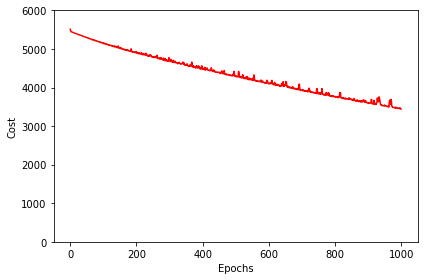

Training accuracy: 92.98%
Test accuracy: 91.85%


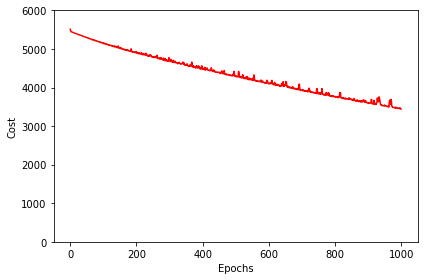

Training accuracy: 92.98%
Test accuracy: 91.85%


In [11]:
nn1 = NeuralNetMLP(n_output=2, 
                  n_features=x_train.shape[1], 
                  n_hidden=10,
                  l2=0.1, 
                  l1=0.1, 
                  epochs=100, 
                  eta=0.0001,
                  alpha=0.1, 
                  decrease_const=0.00001,
                  minibatches=100, 
                  shuffle=True,
                  random_state=1)

nn1.fit(x_train, y_train, print_progress=True)

batches = np.array_split(range(len(nn1.cost_)), 1000)
cost_ary = np.array(nn1.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0, 6000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
#plt.savefig('./figures/cost2.png', dpi=300)
plt.show()

training_accuracy=get_accuracy(nn1, x_train, y_train)
print('Training accuracy: %.2f%%' %training_accuracy)

test_accuracy=get_accuracy(nn1, x_test, y_test)
print('Test accuracy: %.2f%%' %test_accuracy)

import matplotlib.pyplot as plt

batches = np.array_split(range(len(nn1.cost_)), 1000)
cost_ary = np.array(nn1.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]
plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0, 6000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
#plt.savefig('./figures/cost2.png', dpi=300)
plt.show()

training_accuracy=get_accuracy(nn1, x_train, y_train)
print('Training accuracy: %.2f%%' %training_accuracy)

test_accuracy=get_accuracy(nn1, x_test, y_test)
print('Test accuracy: %.2f%%' %test_accuracy)

## Misclassified Sample

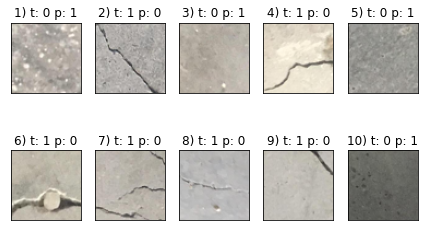

In [12]:
y_test_pred = nn1.predict(x_test)

miscl_img = x_test[y_test != y_test_pred][:10]
correct_lab = y_test[y_test != y_test_pred][:10]
miscl_lab= y_test_pred[y_test != y_test_pred][:10]

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = miscl_img[i].reshape(num_px, num_px, 3)
    ax[i].imshow(img)
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## Correctly classified examples

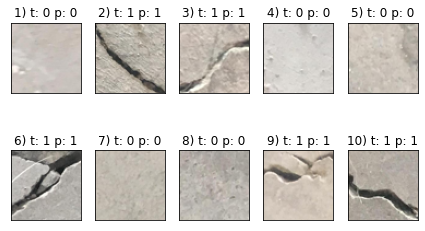

In [13]:
y_test_pred = nn1.predict(x_test)

miscl_img = x_test[y_test == y_test_pred][:10]
correct_lab = y_test[y_test == y_test_pred][:10]
miscl_lab= y_test_pred[y_test == y_test_pred][:10]

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = miscl_img[i].reshape(num_px, num_px, 3)
    ax[i].imshow(img)
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import binarize, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [15]:
def encoder(dataset, catFeatures, qtyFeatures):
    dataset = dataset[catFeatures + qtyFeatures]
    dataset_encoded = pd.get_dummies(dataset, 
                                   columns = catFeatures, 
                                   drop_first = True)
  
    return(dataset_encoded)

def plot_auc_curve(model, X, y):
    try:
        y_pred_prob = model.predict_proba(X)[:,1]
    except:
        d = model.decision_function(X)
        y_pred_prob = np.exp(d) / (1 + np.exp(d))
    
    auc = roc_auc_score(y, y_pred_prob)
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
  
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC Curve\n AUC={auc}'.format(auc = auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)

def model_training(model, X, y):
      model.fit(X,y)
  
      return(model)

def print_accuracy_metrics(model, X, y, threshold):
    try:
        y_pred_prob = model.predict_proba(X)[:,1]
    except:
        d = model.decision_function(X)
        y_pred_prob = np.exp(d) / (1 + np.exp(d))
    y_pred_class = binarize([y_pred_prob], threshold)[0]
    #y_pred_class = binarize(y_pred_prob, threshold)[0]
  
    print("Accuracy:", accuracy_score(y, y_pred_class))
    print("AUC:", roc_auc_score(y, y_pred_prob))
    print("Log Loss:", log_loss(y, y_pred_prob))
    print("Confusion Matrix:\n", confusion_matrix(y, y_pred_class))
    print("Recall:", recall_score(y, y_pred_class))
    print("Precision:", precision_score(y, y_pred_class))


def Find_Optimal_Cutoff(model, X, y):
    try:
        y_pred_prob = model.predict_proba(X)[:,1]
    except:
        d = model.decision_function(X)
        y_pred_prob = np.exp(d) / (1 + np.exp(d))
    
    fpr, tpr, threshold = roc_curve(y, y_pred_prob)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]
  
    print("Optimal Cutoff:", roc_t['threshold'].values)
    return(roc_t['threshold'].values)
  
def feature_importance(model, X):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
               axis=0)
    indices = np.argsort(importances)[::-1]

  # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

  # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
          color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

# Plot calibration plots
def plot_calibration(y_true, y_prob, n_bins, model_name):
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_true, y_prob, n_bins=n_bins)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (model_name, ))

    ax2.hist(y_pred_prob, range=(0, 1), bins=10, label=model_name,
             histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper right", ncol=2)

    plt.tight_layout()
    plt.show()

## MLP Classifier

In [16]:
from sklearn.neural_network import MLPClassifier
NN = MLPClassifier(solver='adam', alpha=0.01,
                     hidden_layer_sizes=(30,20,10), random_state=1, max_iter=100, activation='logistic')

 

model_training(NN, x_train, y_train)
print("\n********************************")
print("\nTraining Error")
print_accuracy_metrics(NN, x_train, y_train, 0.5)

 

print("\n********************************")
print("Test Error")
print_accuracy_metrics(NN, x_test, y_test, 0.5)


********************************

Training Error
Accuracy: 0.8993770764119602
AUC: 0.9337134817539954
Log Loss: 0.268445855303866
Confusion Matrix:
 [[11958   141]
 [ 2282  9699]]
Recall: 0.8095317586178116
Precision: 0.9856707317073171

********************************
Test Error
Accuracy: 0.8858851376603961
AUC: 0.9229203299218096
Log Loss: 0.2933832183108563
Confusion Matrix:
 [[3882   56]
 [ 860 3229]]
Recall: 0.7896796282709709
Precision: 0.9829528158295282


## Logistic Regression

Optimal Cutoff: [0.32917984]

********************************

Training Error
Accuracy: 0.9184385382059801
AUC: 0.9518648141398689
Log Loss: 0.2619560465737226
Confusion Matrix:
 [[11574   525]
 [ 1439 10542]]
Recall: 0.879893164176613
Precision: 0.952561669829222

********************************
Test Error
Accuracy: 0.9029525351937212
AUC: 0.9299797385272656
Log Loss: 0.32679715784271685
Confusion Matrix:
 [[3735  203]
 [ 576 3513]]
Recall: 0.8591342626559061
Precision: 0.9453713670613563


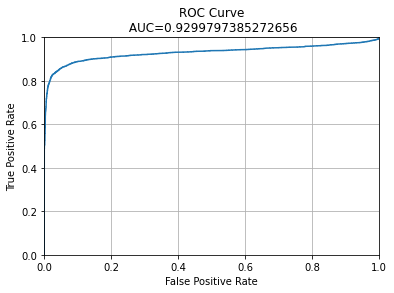

In [17]:
logreg = LogisticRegression()
model_training(logreg, x_train, y_train)

plot_auc_curve(logreg, x_test, y_test)
Find_Optimal_Cutoff(logreg, x_test, y_test)
print("\n********************************")
print("\nTraining Error")
print_accuracy_metrics(logreg, x_train, y_train, 0.5)
print("\n********************************")
print("Test Error")
print_accuracy_metrics(logreg, x_test, y_test, 0.5)

## Gradient Boosting Classifier

In [18]:
from sklearn.ensemble  import GradientBoostingClassifier
gbt = GradientBoostingClassifier(n_estimators=100, learning_rate= 0.15)
model_training(gbt, x_train, y_train)
print("\n********************************")
print("\nTraining Error")
print_accuracy_metrics(gbt, x_train, y_train, 0.5)
print("\n********************************")
print("Test Error")
print_accuracy_metrics(gbt, x_test, y_test, 0.5)


********************************

Training Error
Accuracy: 0.9780730897009967
AUC: 0.9982373529557181
Log Loss: 0.09363485645460816
Confusion Matrix:
 [[12072    27]
 [  501 11480]]
Recall: 0.9581837910024205
Precision: 0.9976536021552098

********************************
Test Error
Accuracy: 0.9628752958764171
AUC: 0.9954843296828403
Log Loss: 0.12081539051047756
Confusion Matrix:
 [[3904   34]
 [ 264 3825]]
Recall: 0.9354365370506236
Precision: 0.9911894273127754


## Random Forest Classifier

Optimal Cutoff: [0.54333333]


array([0.54333333])

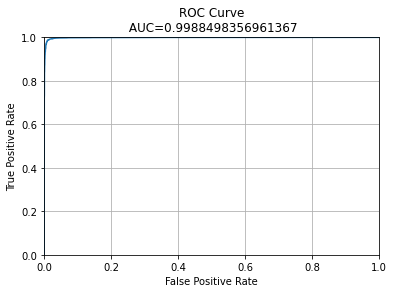

In [19]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
rf = RandomForestClassifier(n_estimators=600, 
                            criterion='gini', 
                            max_features='sqrt',
                            n_jobs=-1)
model_training(rf, x_train, y_train)

 

plot_auc_curve(rf, x_test, y_test)
Find_Optimal_Cutoff(rf, x_test, y_test)

## AdaBoost Classifier

Optimal Cutoff: [0.49692208]

********************************

Training Error
Accuracy: 0.9665282392026578
AUC: 0.9937444035128518
Log Loss: 0.5746348885355732
Confusion Matrix:
 [[12006    93]
 [  713 11268]]
Recall: 0.9404891077539438
Precision: 0.9918141008714022

********************************
Test Error
Accuracy: 0.9502927619284913
AUC: 0.9761614079121466
Log Loss: 0.5762298341919693
Confusion Matrix:
 [[3892   46]
 [ 353 3736]]
Recall: 0.9136708241623869
Precision: 0.98783712321523


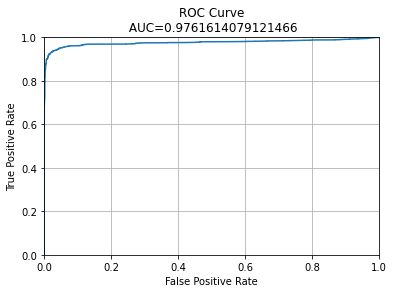

In [20]:
adaBoost = AdaBoostClassifier(n_estimators=150)
model_training(adaBoost, x_train, y_train)

plot_auc_curve(adaBoost, x_test, y_test)
Find_Optimal_Cutoff(adaBoost, x_test, y_test)
print("\n********************************")
print("\nTraining Error")
print_accuracy_metrics(adaBoost, x_train, y_train, 0.5)
print("\n********************************")
print("Test Error")
print_accuracy_metrics(adaBoost, x_test, y_test, 0.5)

In [31]:
test_data_dir = "C:/Users/Ruoxin Wang/Desktop/concerete_crack_images/concerete_crack_images/test/"
test_imgs = os.listdir(test_data_dir)
print(len(test_imgs))

7893


In [32]:
import imageio
import scipy.misc
num_px = 64

def imgPrep(dir, impg_dataset):
    X = np.zeros((len(impg_dataset), num_px*num_px*3))
    y = np.zeros((len(impg_dataset)))
    for i in range(0,len(impg_dataset)) :
    #Read an image from a file as an array.
    #The different colour bands/channels are stored 
    #in the third dimension, such that a 
    #grey-image is MxN, an RGB-image MxNx3 
        image = np.array(imageio.imread(dir + impg_dataset[i])) 
    #image = np.array(imageio.imread(dir + impg_dataset[i]))     
    # Resize the image. Size of the output image (height, width)
        image = Image.fromarray(image).resize(size=(num_px, num_px))
        image = np.array(image)   
    # Convert the matrix to a vector
        image = image.reshape((1, num_px*num_px*3)).T     
    # Note that RGB (Red, Green, Blue) are 8 bit each.
    # Hence, the range for each individual colour is 0-255 (as 2^8 = 256 possibilities).
    # By dividing by 255, Convert the 0-255 range to a 0.0-1.0 range where 0.0 means 0 (0x00) and 1.0 means 255 (0xFF).
        image = image/255.0    
        image = image.reshape((num_px*num_px*3,1))
        for j in range(0,num_px*num_px*3) :
            X[i][j] = image[j][0]        
        if 'Positive' in impg_dataset[i]:
            y[i] = 1
        else:
            y[i] = 0
    y = y.astype(int)  
    return(X)

def get_accuracy(model, X, y):
    y_pred = model.predict(X)
    if sys.version_info < (3, 0):
        accuracy = ((np.sum(y == y_pred, axis=0)).astype('float') /
            X.shape[0])
    else:
        accuracy = np.sum(y == y_pred, axis=0) / X.shape[0]
  #print('Accuracy: %.2f%%' % (accuracy * 100))  
    return(accuracy * 100)


In [33]:
X_test = imgPrep(test_data_dir, test_imgs)

In [34]:
X_test

array([[0.65882353, 0.65490196, 0.64705882, ..., 0.60392157, 0.60392157,
        0.60392157],
       [0.75294118, 0.71764706, 0.69803922, ..., 0.69019608, 0.67843137,
        0.65098039],
       [0.69019608, 0.65882353, 0.61568627, ..., 0.7372549 , 0.7254902 ,
        0.69803922],
       ...,
       [0.79607843, 0.76078431, 0.7254902 , ..., 0.69019608, 0.67843137,
        0.63137255],
       [0.72941176, 0.72156863, 0.6745098 , ..., 0.74117647, 0.72156863,
        0.69803922],
       [0.58823529, 0.60392157, 0.60784314, ..., 0.56470588, 0.58039216,
        0.56862745]])

In [35]:
prediction = gbt.predict(X_test)

In [36]:
prediction

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
prediction = pd.DataFrame(prediction, columns = ['Predictions'])
prediction

,Predictions
0,0
1,0
2,0
3,0
4,1
...,...
7888,0
7889,1
7890,0
7891,0


In [38]:
test_imgs1 = pd.DataFrame(test_imgs, columns=['ID'])
test_imgs1

,ID
0,1000016480768558.png
1,1000094138882661.png
2,100010347143101.png
3,1000228345963509.png
4,10002760868742.png
...,...
7888,998571566265837.png
7889,998643968970504.png
7890,998973470469203.png
7891,999190422899601.png


In [39]:
prediction['ID'] = test_imgs1
prediction['Predictions'] = prediction
prediction

,Predictions,ID
0,0,1000016480768558.png
1,0,1000094138882661.png
2,0,100010347143101.png
3,0,1000228345963509.png
4,1,10002760868742.png
...,...,...
7888,0,998571566265837.png
7889,1,998643968970504.png
7890,0,998973470469203.png
7891,0,999190422899601.png


In [40]:
prediction.to_csv('prediction.csv')